# 1. Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from catboost import CatBoostClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.model_selection import train_test_split

from IPython.display import Image
import graphviz

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Failed to import duecredit due to No module named 'duecredit'


# 2. Импорт данных

In [2]:
df = pd.read_csv("criteo-uplift-v2.1.csv", sep=",", decimal=';')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616364906986497,10.059654474774547,8.976428838331028,4.679881620097284,10.280525225748212,4.115453421277861,0.29444271125560606,4.833814577796811,3.9553959684262416,13.190055934673358,5.300374864042156,-0.16867922100056124,1,0,0,0
1,12.616364906986497,10.059654474774547,9.002689495197341,4.679881620097284,10.280525225748212,4.115453421277861,0.29444271125560606,4.833814577796811,3.9553959684262416,13.190055934673358,5.300374864042156,-0.16867922100056124,1,0,0,0
2,12.616364906986497,10.059654474774547,8.964775175534072,4.679881620097284,10.280525225748212,4.115453421277861,0.29444271125560606,4.833814577796811,3.9553959684262416,13.190055934673358,5.300374864042156,-0.16867922100056124,1,0,0,0
3,12.616364906986497,10.059654474774547,9.002800861653911,4.679881620097284,10.280525225748212,4.115453421277861,0.29444271125560606,4.833814577796811,3.9553959684262416,13.190055934673358,5.300374864042156,-0.16867922100056124,1,0,0,0
4,12.616364906986497,10.059654474774547,9.037998700075555,4.679881620097284,10.280525225748212,4.115453421277861,0.29444271125560606,4.833814577796811,3.9553959684262416,13.190055934673358,5.300374864042156,-0.16867922100056124,1,0,0,0


In [3]:
# Возьмем 20% от данных ввиду ограничений по характеристикам "железа"
df = df.sample(int(len(df)*0.2)).reset_index(drop=True)

In [4]:
# Преобразуем типы строк на float 
columns_to_float = df.iloc[:, :-4].columns
for col in tqdm(columns_to_float):
    df[col] = df[col].astype(float)

  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
# Посмотрим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795918 entries, 0 to 2795917
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 341.3 MB


In [6]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06,2.795918e+06
mean,1.961809e+01,1.006993e+01,8.446541e+00,4.179212e+00,1.033879e+01,4.028521e+00,-4.155059e+00,5.101923e+00,3.933601e+00,1.602294e+01,5.333446e+00,-1.709589e-01,8.500135e-01,2.904592e-03,4.709652e-02,3.080634e-02
std,5.379077e+00,1.043562e-01,2.993377e-01,1.335451e+00,3.430274e-01,4.312970e-01,4.577732e+00,1.205826e+00,5.665366e-02,7.013575e+00,1.683882e-01,2.276047e-02,3.570583e-01,5.381595e-02,2.118453e-01,1.727927e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-7.700578e+00,1.028053e+01,-7.815454e+00,-3.041916e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192364e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443683e+01,1.005965e+01,8.723691e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.498054e+01,9.051961e+00,4.679882e+00,2.036660e+01,4.115453e+00,2.944427e-01,1.199839e+01,3.971858e+00,6.772867e+01,6.473915e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# Проверим пропуски
df.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [8]:
# Посмотрим распределение признака treatment в нашей выборке
df['treatment'].value_counts(normalize = True)

1    0.850013
0    0.149987
Name: treatment, dtype: float64

In [9]:
# Проверим пропуски на диаграмме
# colours = ['#000099', '#ffff00'] 
# sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

**Вывод по данным:**
* Пропусков в данных нет;
* Значнеие признаков:
    - f0-f10 - предикторы;
    - treatment - признак взаимодействия с пользователем;
    - conversion - произошла ли конверсия для этого пользователя;
    - visit - произошло ли посещение для этого пользователя;
    - exposure - эффект от взаимодействия, был ли пользователь эффективно выставлен.
* Критичных аномалий в данных на первый взгляд не наблюдается. 

In [10]:
# Возьмем функцию для оценки Qini curve с прошлого занятия
def qini_df(df):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [11]:
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [12]:
# Вынесем колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
target_col = 'visit'
treatment_col = 'treatment'

In [13]:
def target_class(df, treatment, target):
    """
    Функция для создания класса:
    0 - взаимодействия с пользователем не было, действий от пользователя не было
    1 - взаимодействия с пользователем не было, действие от пользователя было
    2 - взаимодействия с пользователем было, действий от пользователя не было
    3 - взаимодействия с пользователем было, действие от пользователя было
    """
    
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0), 'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0), 'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0), 'target_class'] = 3 
    return df

In [14]:
# Создадим признак с классом
df = target_class(df, 'treatment', 'visit')
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
0,22.538558,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
1,23.052409,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
2,18.457135,10.059654,8.214383,2.293959,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
3,26.550910,10.059654,8.214383,4.679882,10.280525,4.115453,-5.987667,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
4,22.486325,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795913,22.465031,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0,0
2795914,25.106423,10.059654,8.214383,4.679882,10.280525,4.115453,-9.238756,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
2795915,16.438260,10.059654,8.214383,-0.716053,10.280525,4.115453,-11.094475,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
2795916,12.616365,10.059654,8.596953,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,18.380112,5.300375,-0.168679,1,0,0,0,2


In [15]:
# Разобъем нашу выборку на тестовую и валидационную
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=13, test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
124661,12.616365,10.059654,8.936365,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679,1,0,0,0,2
2755260,21.954163,10.059654,8.214383,4.679882,10.280525,4.115453,-6.359690,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
1395554,25.544969,10.059654,8.214383,4.679882,10.280525,4.115453,-9.564219,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0,0
1288917,12.616365,10.059654,8.629156,4.679882,10.280525,4.115453,0.294443,4.833815,3.902645,25.954644,5.300375,-0.168679,0,0,0,0,0
2207986,25.395964,10.059654,8.214383,4.679882,10.280525,4.115453,-10.403862,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0,0


# S-learner

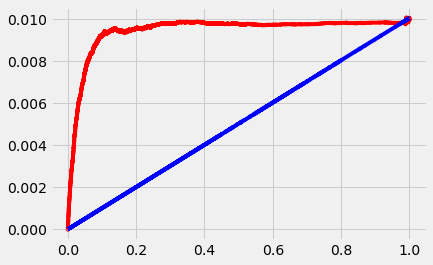

3693.5897999999993

In [16]:
# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нужнен датафрем с факторами, колонка с фактом воздействия, целевая переменная
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Посмотрим результаты на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

# T-learner

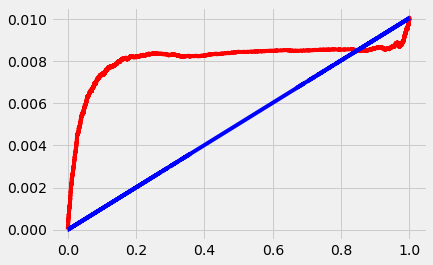

2575.779219999998

In [17]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нужнен датафрем с факторами, колонка с фактом воздействия, целевая переменная
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Посмотрим результаты на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

# X-learner

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

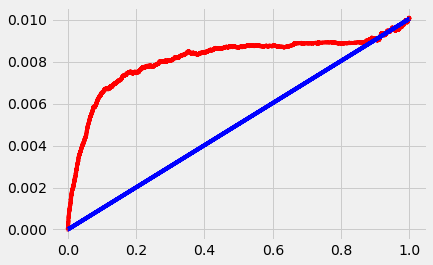

2571.4915199999996

In [18]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=13),
                           effect_learner=LinearRegression())

# Для обучения нужнен датафрем с факторами, колонка с фактом воздействия, целевая переменная
x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Посмотрим результаты на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

# R-learner

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

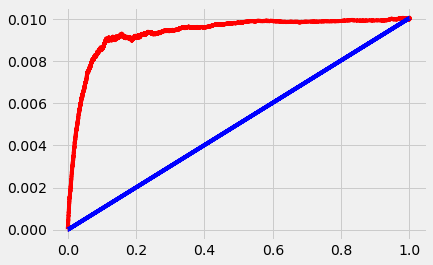

3622.5047900000013

In [19]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(),
                            effect_learner=LinearRegression())

# Для обучения нужнен датафрем с факторами, колонка с фактом воздействия, целевая переменная
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Посмотрим результаты на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

# UpliftRandomForestClassifier

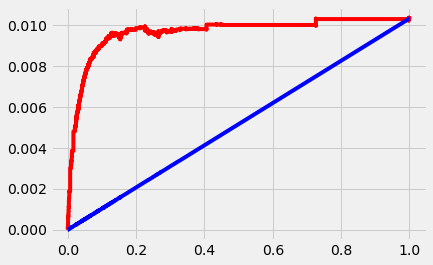

3760.7679699999994

In [16]:
# Создадим базовый UpliftRandomForestClassifier
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

# Для обучения нужнен датафрем с факторами, колонка с фактом воздействия, целевая переменная
uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

# Посмотрим результаты на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

**Вывод.** 
В данном кейсе получились следующие результаты:
 - самый лучший результат показал UpliftRandomForestClassifier, т.к. у него самая лучшая метрика qini = 3762,77;
 - S-learner qini = 3693.58;
 - X-learner qini = 3622.5.
  